# Исследование структуры и содержания спортивных новостей на сайте MatchTV с целью выявления наиболее популярных тематик и анализа текстовых характеристик публикаций


## Описание

Данный проект направлен на автоматизированный сбор, обработку и анализ спортивных новостей с официального сайта телеканала Матч ТВ — matchtv.ru.
Основная цель исследования — изучение структуры и содержания спортивной медиаповестки, выявление наиболее популярных тем, а также анализ текстовых характеристик новостных публикаций.

Проект реализуется с использованием языка программирования Python и библиотек requests, BeautifulSoup, pandas, matplotlib и seaborn. Данные для исследования берутся с официального сайта спортивного телеканала MatchTV.ru (https://matchtv.ru/news) в колиестве 250 штук, каждая новость охватывает различные виды спорта.


In [67]:
pip install dostoevsky

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp311-cp311-linux_x86_64.whl size=4304103 sha256=c524334ca28196c30613681e174b466aac5f613a14d7a79892b33bde29908d0e
  Stored in directory: /root/.cache/pip/wheels/12/89/c9/c932d04c4dd65abe347bbb3e6f7668688753cbc585305ad8b7
Successfully built fasttext


In [65]:
!python -m dostoevsky download fasttext-social-network-model

/usr/bin/python3: No module named dostoevsky


In [83]:
import requests
from bs4 import BeautifulSoup
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud
import re
from pymystem3 import Mystem
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from collections import Counter
import networkx as nx

## Загрузка данных

Парсинг данных будет представлен в файле parsing.py, однако продублирую код получения 250 последних новостей с сайта https://matchtv.ru/news. Рассмотрим код более подробно:
<br>
<br>
В основе кода лежат функции requests и BeautifulSoupДля каждой новости скрипт извлекает URL, заголовок, тему (например, "Футбол", "Хоккей" и т.д.), а также полный текст самой статьи. Полученные данные сохраняются в структурированном формате JSON в файл matchtv_news.json. В результате в выходном JSON-файле каждая новость представлена в виде словаря с ключами: url, title, topic, text. Для избежания блокировок и чрезмерной нагрузки на сервер используется небольшая задержка (time.sleep) между запросами.
<br>
<br>
Для удобства логика кода была разделена на 3 основных функции:
1. get_news_list. Скрипт итерируется по страницам сайта, пока не соберёт необходимое количество новостей, используя библиотеку BeautifulSoup для HTML-разметки. На этапе сбора с карточки новости извлекаются её URL, заголовок и тема;
2. get_article_text. На предыдущем этапе мы находим ссылки интересующих нас новостей. Данная функция получает на вход ссылку из найденных новостей, а далее находит все блоки текста с тегом < p > и склеивает их, чтобы на выходе в ключ "text" был записан полноценный текст новости;
3. collect_full_news. Собираем воедино все найденные данные для дальнейшей записи в json-файл. Проходимся по всем объектам из результатов работы функции get_news_list и дорабатываем тексты новостей.

In [1]:
BASE_URL = "https://matchtv.ru"
NEWS_URL = f"{BASE_URL}/news"

In [17]:
def get_news_list(num_news=500):
    news_items = []
    page = 1
    while len(news_items) < num_news:
        response = requests.get(f"{NEWS_URL}?page={page}")
        if response.status_code != 200:
            print(f"Ошибка при загрузке страницы {page}")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        articles = soup.find_all("a", class_="node-news-list__item")
        for article in articles:
            href = article.get("href")
            full_url = BASE_URL + href
            title_elem = article.find("div", class_="node-news-list__title")
            title = title_elem.get_text(strip=True) if title_elem else "Нет заголовка"
            topic_elem = article.find_all("li", class_="credits__item")
            topic = topic_elem[1].get_text(strip=True) if topic_elem else "Нет темы"
            news_items.append({
                "url": full_url,
                "title": title,
                "topic": topic
            })
            if len(news_items) >= num_news:
                break

        time.sleep(0.5)
    return news_items

In [18]:
def get_article_text(url):
    response = requests.get(url)
    if response.status_code != 200:
        return "Ошибка загрузки текста"
    soup = BeautifulSoup(response.text, "html.parser")
    content_div = soup.find("div", class_="article__content")
    if not content_div:
        return "Нет основного текста"
    paragraphs = content_div.find_all("p")
    text = "\n".join(p.get_text(strip=True) for p in paragraphs)
    return text

In [19]:
def collect_full_news(num_news=500):
    news_list = get_news_list(num_news)
    for i, news in enumerate(news_list):
        news["text"] = get_article_text(news["url"])
        time.sleep(0.5)
    return news_list

In [20]:
all_news = collect_full_news(num_news=500)
with open("matchtv_news.json", "w", encoding="utf-8") as f:
    json.dump(all_news, f, ensure_ascii=False, indent=4)

## Очистка данных и подготовка к анализу

После проведения парсинга данных и получения готового файла в json-формате сохраним их в датасет

In [21]:
df = pd.read_json("matchtv_news.json", encoding="utf-8")
df.head()

,url,title,topic,text
0,https://matchtv.ru/football/matchtvnews_NI2199...,«Марсель» сыграл вничью с «Лиллем» в матче 32‑...,Футбол,«Марсель»сыграл вничью с«Лиллем»в гостевом мат...
1,https://matchtv.ru/football/matchtvnews_NI2199...,Пономарев — о волевой победе «Зенита» над «Пар...,Футбол,Главный тренер «Зенита»Сергей Семакв матче с «...
2,https://matchtv.ru/football/matchtvnews_NI2199...,Коршунов: «Спартак» обязан попасть в тройку. З...,Футбол,Настрой на победу в Кубке России после потери ...
3,https://matchtv.ru/football/matchtvnews_NI2199...,"Футболист «Ростова» Голенков: «Надеюсь, на сле...",Футбол,Нападающий «Ростова»Егор Голенковв разговоре с...
4,https://matchtv.ru/football/matchtvnews_NI2199...,«Не хватало необходимой агрессии» — футболист ...,Футбол,Полузащитник «Зенита»Александр Ерохинпосле мат...


Посомтрим на типы данных, которые представлены в датасете

In [27]:
df.dtypes

,0
url,object
title,object
topic,object
text,object


На этапе парсинга я устанавливала проверки на отсутствие заголока или текста (в случае переоев в работе кода, когда программе не удалось найти нужный html тег с интересующим содержимым). Посмотрим, присутствуют ли в моем датасете значения "Нет заголовка" и "Нет темы" и "Нет основго текста"

In [28]:
no_title = df[df['title'] == 'Нет заголовка']
no_topic = df[df['topic'] == 'Нет темы']
no_text = df[df['text'] == 'Нет основного текста']

print(f"Количество строк с отсутствующим заголовком: {len(no_title)}")
print(f"Количество строк с отсутствующей темой: {len(no_topic)}")
print(f"Количество строк с отсутствующим текстом: {len(no_text)}")

Количество строк с отсутствующим заголовком: 0
Количество строк с отсутствующей темой: 0
Количество строк с отсутствующим текстом: 0


Добавим немного визуализации. Посмотрим, как распределяются темы новостей

<ipython-input-108-2369cb52f32c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='coolwarm')


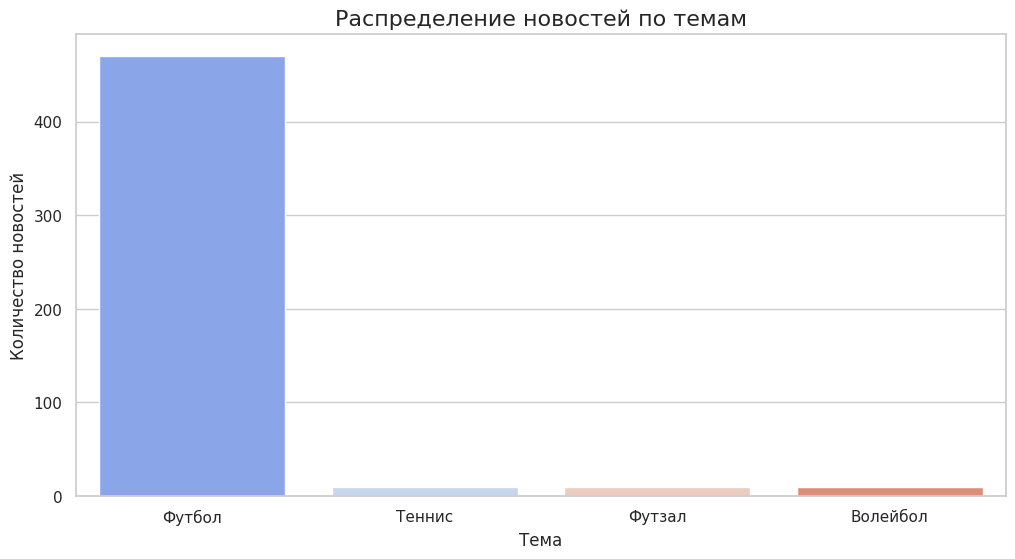

In [108]:
sns.set(style="whitegrid")
topic_counts = df['topic'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='coolwarm')
plt.title("Распределение новостей по темам", fontsize=16)
plt.xlabel('Тема', fontsize=12)
plt.ylabel('Количество новостей', fontsize=12)
plt.savefig('topics.png', format='PNG', dpi=300)
plt.show()

Как можно заметить, практически все новости о футболе, лишь небольшое количество из полученных относится к теме "Теннис" и "Волейбол" (Футзал тоже является подвидом футбола)

Теперь проанализируем длину текстов в новостях, чтобы понять, есть ли какие-то аномалии или экстремальные значения. Для этого добавим вспомогательный числовой столбец, который будет содержать в себе длину текста (колчиество символов в каждой новости)

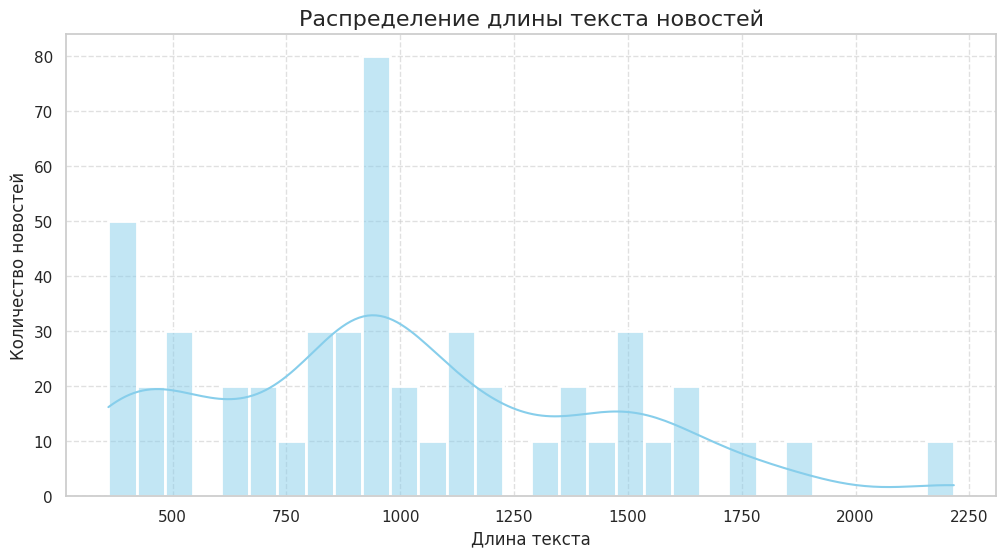

In [100]:
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12,6))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue', linewidth=2)
plt.title("Распределение длины текста новостей", fontsize=16)
plt.xlabel('Длина текста', fontsize=12)
plt.ylabel('Количество новостей', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('text_length.png', format='PNG', dpi=300)
plt.show()

Заметны некоторые аномалии, а именно размер новостей сильно варьируется, наиболее часто употребляемый размер - около 900-950 символов, однако присутствуют как короткие новости (длинной 350-400 символов), так и большие корпуса текста (от 1500+ символов)

Напоследок пред этапом полноценного анализа создадим отдельный стобец с очищенным текстом. Для этого напишем функцию, которая будет токенизировать текст, удалять пунктуацию и стоп слова

In [46]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

def clean_text(text):
    text = text.replace('«', '').replace('»', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'http\S+', '', text)
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('russian'))
    cleaned_tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(cleaned_tokens)

df['cleaned_text'] = df['text'].dropna().apply(clean_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,url,title,topic,text,text_length,cleaned_text
0,https://matchtv.ru/football/matchtvnews_NI2199...,«Марсель» сыграл вничью с «Лиллем» в матче 32‑...,Футбол,«Марсель»сыграл вничью с«Лиллем»в гостевом мат...,626,марсель сыграл вничью слиллем гостевом матче 3...
1,https://matchtv.ru/football/matchtvnews_NI2199...,Пономарев — о волевой победе «Зенита» над «Пар...,Футбол,Главный тренер «Зенита»Сергей Семакв матче с «...,1211,главный тренер зенита сергей семакв матче пари...
2,https://matchtv.ru/football/matchtvnews_NI2199...,Коршунов: «Спартак» обязан попасть в тройку. З...,Футбол,Настрой на победу в Кубке России после потери ...,1650,настрой победу кубке россии потери шансов золо...
3,https://matchtv.ru/football/matchtvnews_NI2199...,"Футболист «Ростова» Голенков: «Надеюсь, на сле...",Футбол,Нападающий «Ростова»Егор Голенковв разговоре с...,905,нападающий ростова егор голенковв разговоре ма...
4,https://matchtv.ru/football/matchtvnews_NI2199...,«Не хватало необходимой агрессии» — футболист ...,Футбол,Полузащитник «Зенита»Александр Ерохинпосле мат...,1533,полузащитник зенита александр ерохинпосле матч...


Теперь у нас есть очищенный текст, смело переходим к этапу глубоко анализа

## Анализ и визуализация

После проведения базового анализа исходных данных перейдем к более глубокому анализу новостей

### Частотный анализ. Облако слов

Для того чтобы увидеть самые часто встречающиеся слова, применим токенизацию текста и построим облако слов с применением бибилотеки wordcloud. Но для начала приведем наш чистый текст к леммам, это сделает анализ более точным и грамотным

In [50]:
all_text = ' '.join(df['cleaned_text'])
m = Mystem()

def lemmatize(string):
    lemmas = m.lemmatize(string)
    return ''.join(lemmas)

lemmatized_text = lemmatize(all_text)
lemmatized_text

'марсель сыграть вничью слилль гостевой матч 32го тур чемпионат франция футбол встреча завершаться счет 11 состав хозяин поле отличаться матиас фернандеспардо гость гол забивать амин гуири марсель набирать 59 очки идти второй таблица лига 1 лилль 57 очки располагаться пятый строчка следующий тур 10 май марсель гость встречаться гавр лилль день сыграть выезд брест лилль лилль марсель марсель 1100 голыфернандеспардо 75 гуири 57 новость спорт нашемтелеграмканал главный тренер зенит сергей семаква матч пари нн перестраивать игра добиваться победа благодаря это заявлять матч тв бывший защитник цска владимир пономарев петербургскийзенит воскресение дом одерживать волевой победа пари нн матч 27го тур мир рпл счет 21 гость выходить вперед 14й минута благодаря точный удар вячеслав грулев синебелоголубой дубль оформлять александр соболев 54 83 сережа семак матч пари нн переделывать игра угадывать рано показывать комбинационный игра сыграть простой столб навес фланг это приносить большой польза п

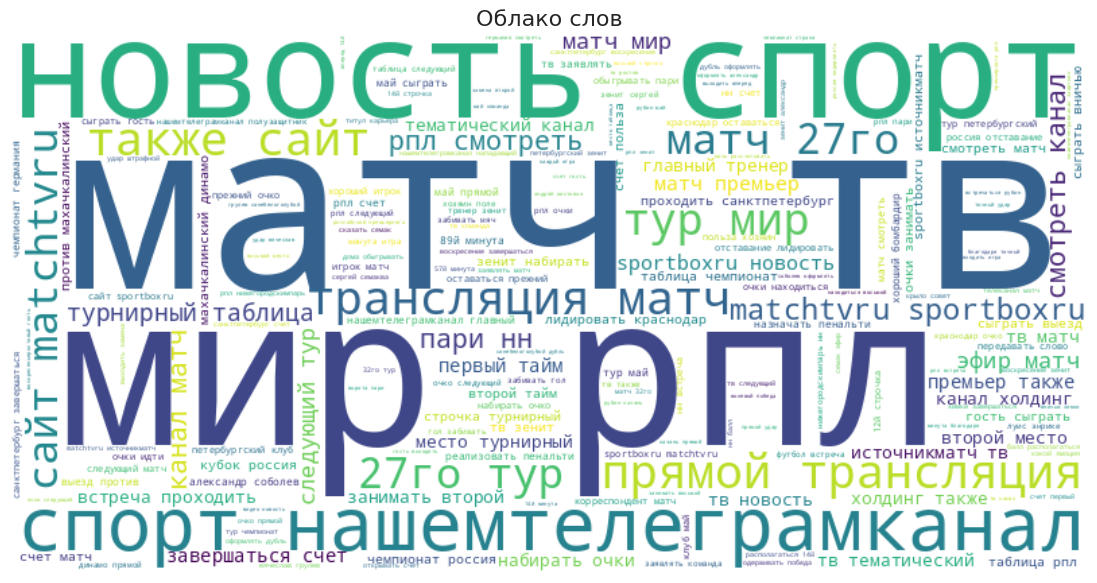

In [52]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lemmatized_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов', fontsize=16)
plt.show()

Заметно, что самые часто употребляемые слова это: новость, спорт, матч, тв, мир, рпл. Это воплне ожидаемо, поэтому удалим эти слова и вновь посомтрим на облоко слов уже без стоп слов, которые можно смело выделить в рамках нашего проекта

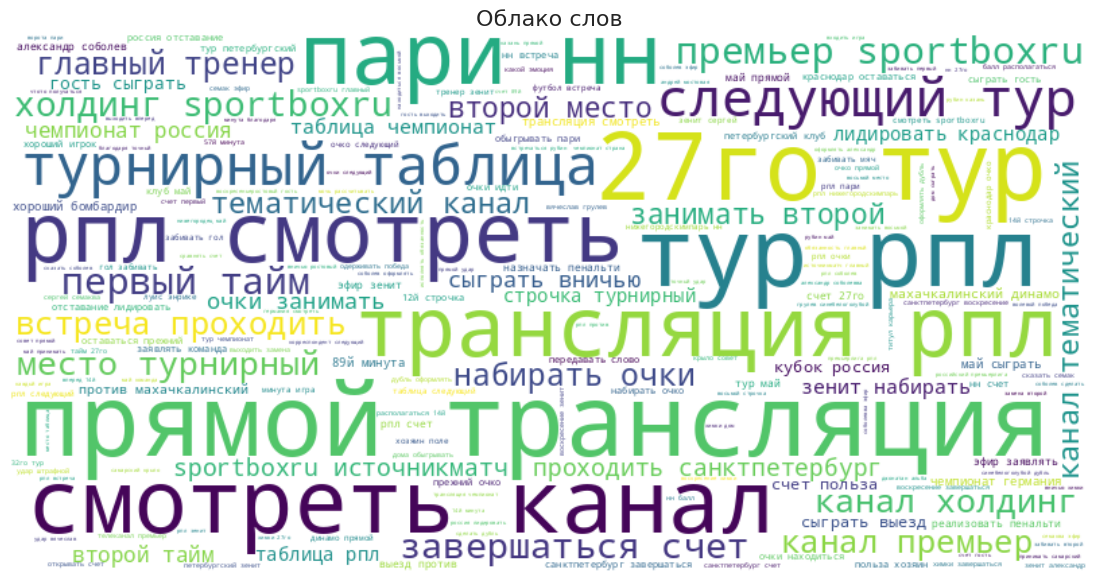

In [99]:
new_stop_words = ["новость", "спорт", "матч", "тв", "мир", "нашемтелеграмканал", "также", "сайт", "matchtvru"]
filtered_words = [word for word in lemmatized_text.split() if word not in new_stop_words]

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов', fontsize=16)
plt.savefig('word_cloud.png', format='PNG', dpi=300)
plt.show()

Уже лучше, сразу заметно, что большинство новостей направлено на информаирование читателей о результатах РПЛ, прямых трансляциях, призыв к просмотру телеканала, каких-то матчах и событиях

### Частотный анализ клубов РПЛ

Так как ранее мы уже определили, что практически все новости относятся к тематике футбола, посмотрим на частоту упоминания конкретных футбольных команд. Для этого создадим список ключевых слов и проверим их частоту в тексте

<ipython-input-98-0d00ca04f906>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(mention_counts.keys()), y=list(mention_counts.values()), palette='coolwarm')


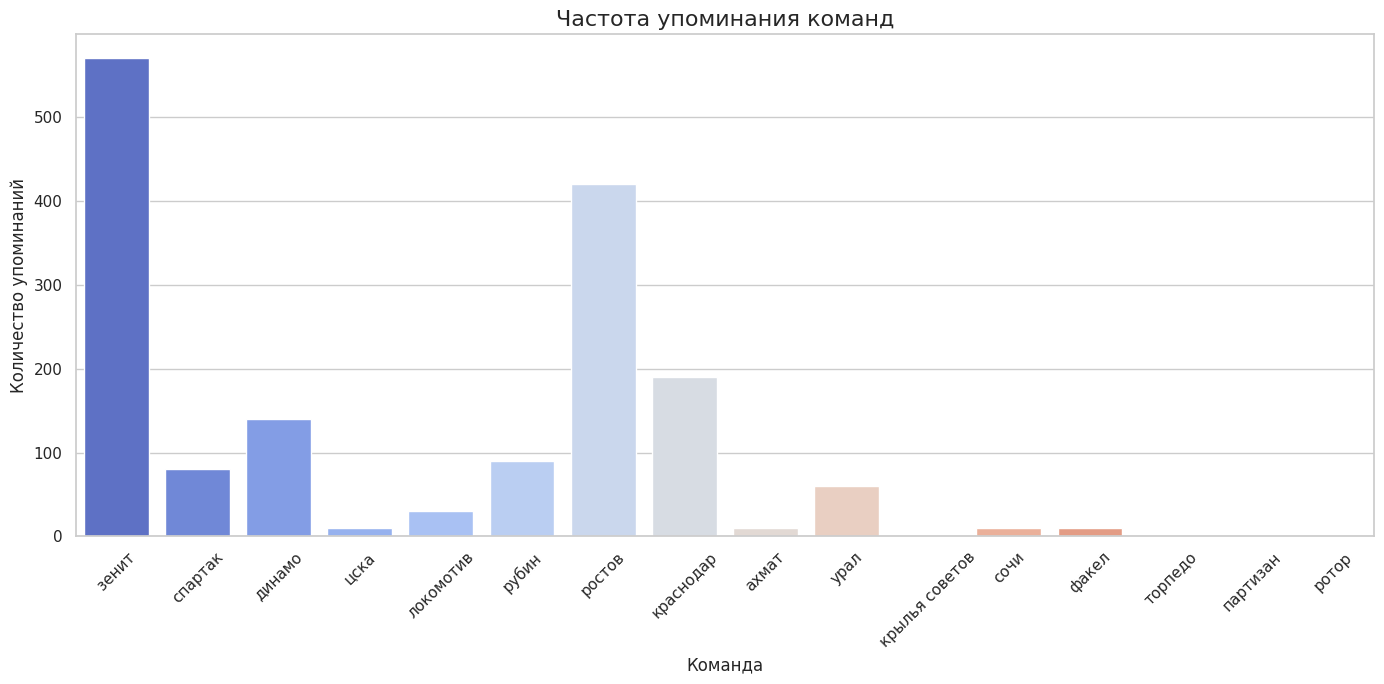

In [98]:
teams = ["зенит", "спартак", "динамо", "цска", "локомотив", "рубин", "ростов", "краснодар", "ахмат", "урал", "крылья советов", "сочи", "факел", "торпедо", "партизан", "ротор"]

mention_counts = {team: lemmatized_text.count(team) for team in teams}

plt.figure(figsize=(14, 7))
sns.barplot(x=list(mention_counts.keys()), y=list(mention_counts.values()), palette='coolwarm')
plt.title('Частота упоминания команд', fontsize=16)
plt.xlabel('Команда', fontsize=12)
plt.ylabel('Количество упоминаний', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_teams.png', format='PNG', dpi=300)
plt.show()

Как итог: Зенит, Ростов и Краснодар самые часто употреблемые в текстах, а значит большое количество новостей посвящено им. Это может быть связано с обширным количеством матчей в последнее время, трансферами, событиями или победами в рамках турниров

### Топ часто употребляемых слов

Выведем ТОП-10 часто употребляемых слов, будем использовать привычным подсчет, а результат хранить в слвоаре, где ключ - слово, а занчение - количество в тексте

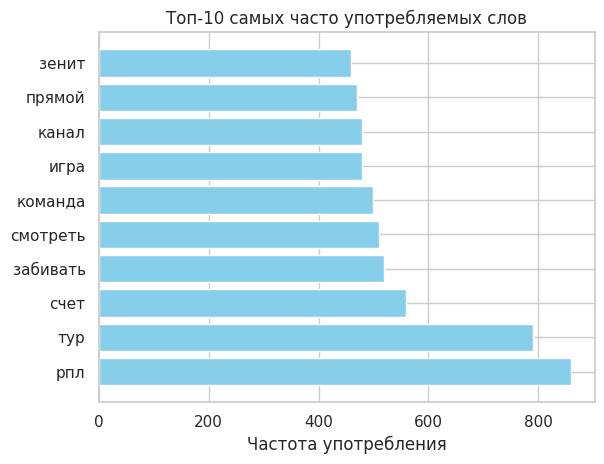

In [97]:
word_freq = {}
for word in filtered_words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1


sorted_word_freq = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1], reverse=True)}
top_words = list(sorted_word_freq.keys())[:10]
top_word_freq = [sorted_word_freq[word] for word in top_words]


plt.barh(top_words, top_word_freq, color="skyblue")
plt.xlabel('Частота употребления')
plt.title('Топ-10 самых часто употребляемых слов')
plt.savefig('top-10.png', format='PNG', dpi=300)
plt.show()

### Графы

Будем смотреть на связи между наиболее часто встречающимися словами в тексте. Для этого возьмем отфильтрованный текст и создадим биграммы. Биграммы - это пары слов, котоыре вместе встречаются в тексте. В качестве результата выведем ТОП-10 самых частых биграмм

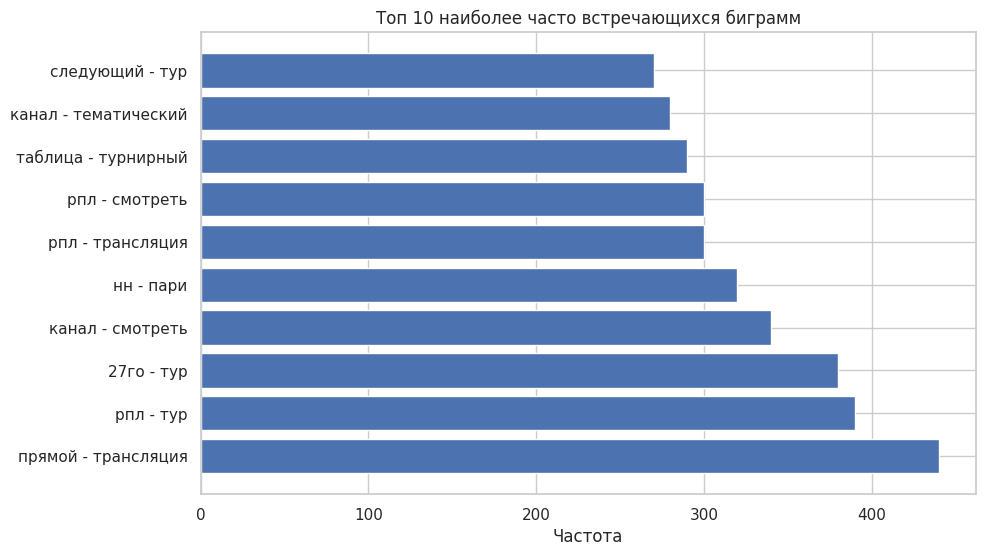

In [96]:
import nltk
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt


pairs = [tuple(sorted(pair)) for pair in nltk.bigrams(filtered_words)]
word_pairs = dict(Counter(pairs))

filtered_pairs = [(pair[0], pair[1], val) for pair, val in word_pairs.items() if val > 5]

top_pairs = sorted(filtered_pairs, key=lambda x: x[2], reverse=True)[:10]
words_1, words_2, counts = zip(*top_pairs)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_pairs)), counts, tick_label=[f"{w1} - {w2}" for w1, w2 in zip(words_1, words_2)])
plt.xlabel('Частота')
plt.title('Топ 10 наиболее часто встречающихся биграмм')
plt.savefig('bigrams.png', format='PNG', dpi=300)
plt.show()

Заметно, что биграммы можно разделить на несколько категорий:
- Информационная справка о трансляциях, канале в телеграмм, призывы к действию
- Туры РПЛ
- Новости о футбольном клубе "Пари НН"
- Результаты матчей

А теперь построим полноценный граф, чтобы отследить зависимости биграмм друг от друга

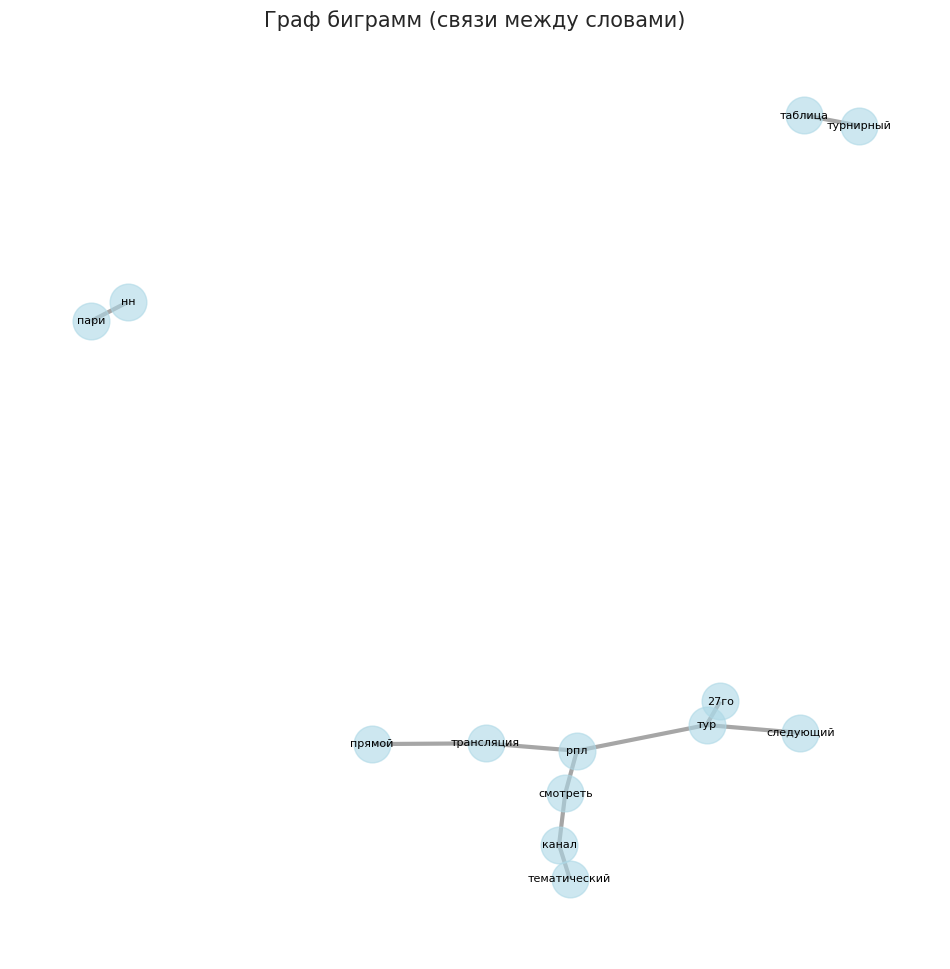

In [95]:
G = nx.Graph()

filtered_pairs = [(pair[0], pair[1], val) for pair, val in word_pairs.items() if val > 200]

for (w1, w2, weight) in filtered_pairs:
    if not G.has_node(w1):
        G.add_node(w1)
    if not G.has_node(w2):
        G.add_node(w2)
    G.add_edge(w1, w2, weight=weight)


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', alpha=0.6)
nx.draw_networkx_edges(G, pos, width=3, alpha=0.7, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title('Граф биграмм (связи между словами)', fontsize=15)
plt.axis('off')
plt.savefig('graph.png', format='PNG', dpi=300)
plt.show()

Для более наглядного и четкого графв было принято решение брать биграммы, которые употребляются более 200 раз. Как можно заметить, граф разделился на 3 области: турнирная таблица (результаты матчей), футбольный клуб "Пари НН" и трансляции матчей

## Выводы

Основные выводы из глубокого анализа новостей:

- Преобладание футбольных новостей: почти все новости на сайте посвящены футболу, что подтверждает, что футбол является самой популярной темой среди публикуемых материалов. Малое количество новостей было посвящено другим видам спорта, это свидетельствует о фокусе телеканала на футболе.

- Аномалии в длине текстов: длина текстов варьируется от коротких новостей до крупных публикаций, что указывает на разнообразие представленных материалов. В большинстве случаев тексты имеют длину около 900-950 символов, однако существуют и аномалии, что требует дополнительного внимания к стандартизации контента.

- Частотный анализ и облако слов: часто встречающиеся слова в новостях включают такие термины, как "новость", "спортивные события", "матч", что отражает основной контекст информации. Применение лемматизации и фильтрация стоп-слов позволило выделить ключевые темы и события, такие как РПЛ (Российская премьер лига), трансляции матчей и достижения футбольных команд.

- Анализ упоминаний клубов РПЛ: Зенит, Ростов и Краснодар стали самыми часто упоминаемыми клубами, что, вероятно, связано с их активным участием в соревнованиях и важных спортивных событиях в последнее время. Это подтверждает интерес аудитории к новостям, связанным с этими клубами.

- Графы и биграммы: построенные графы и анализ биграмм показали важные связи между словами, такими как упоминания команд, трансляции матчей и турнирные события. Эти графы помогают визуализировать структуру информации и выявить наиболее важные взаимосвязи в новостях.

## Обсуждение

В рамках данного проекта была проведена всесторонняя обработка, анализ и визуализация спортивных новостей с официального сайта телеканала Матч ТВ. Основная цель исследования заключалась в изучении структуры и содержания спортивной медиаповестки, а также в выявлении наиболее популярных тем и клубов, что позволило глубже понять, какие события и спортивные дисциплины привлекают наибольшее внимание аудитории.

Проект также дал возможность наглядно представить результаты через различные графики и облака слов, что позволяет более детально анализировать структуру новостной ленты.

Таким образом, данный анализ позволил не только выявить ключевые темы в спортивной медиаповестке, но и сформировать рекомендации для более эффективного создания контента, адаптированного под интересы аудитории. Это исследование может служить основой для дальнейшего анализа трендов в спортивной журналистике и потребностей зрителей.